## Notebook de Consolidação e Análise de Resultados
 
Este notebook é dedicado a carregar, consolidar e analisar os resultados dos experimentos de replicação (Fiel e Otimizada) e compará-los diretamente com os resultados do artigo original.

**Objetivos:**
1. Carregar os dados de métricas do artigo original (Tabelas 4, 5, 6).
2. Carregar os dados de métricas (holdout e backtest) gerados pelos scripts de replicação para todas as 12 cidades.
3. Consolidar tudo em DataFrames.
4. Gerar tabelas e visualizações comparativas para o relatório final.

### 1. Configuração e Importação

In [110]:
!pip install seaborn scikit-posthocs

In [111]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [112]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
ANALYSIS_FOLDER='analysis'

### 2. Utilitários

In [113]:
def coerce_numeric(df, cols):
  for c in cols:
    if c in df.columns:
      df[c] = pd.to_numeric(df[c], errors='coerce')
  return df

def load_replication_results(base_path="results"):
  """
  Carrega todos os CSVs de results/replicacao_fiel e results/replicacao_otimizada,
  inferindo 'Type' pelo nome do arquivo e 'City' pela coluna Station (fallback: nome de arquivo).
  """
  all_results = []
  for approach in ['replicacao_fiel', 'replicacao_otimizada']:
    approach_dir = os.path.join(base_path, approach)
    if not os.path.isdir(approach_dir):
      print("Aviso: diretório não encontrado:", approach_dir)
      continue
    for fname in os.listdir(approach_dir):
      if not fname.endswith(".csv"): 
        continue
      fpath = os.path.join(approach_dir, fname)
      try:
        df_tmp = pd.read_csv(fpath)
      except Exception as e:
        print("Falha ao ler:", fpath, e); 
        continue

      # Tipo (holdout/backtesting)
      if fname.endswith('_backtesting_mean.csv'):
        df_tmp['Type'] = 'Backtest_Mean'
      elif fname.endswith('_backtesting_full.csv'):
        df_tmp['Type'] = 'Backtest_Full'
      else:
        df_tmp['Type'] = 'Holdout'

      # Cidade (preferir coluna Station)
      city = None
      if 'Station' in df_tmp.columns and pd.notna(df_tmp['Station']).any():
        city = df_tmp['Station'].dropna().iloc[0]
      if not city or not isinstance(city, str):
        city = fname.replace('_backtesting_mean.csv','').replace('_backtesting_full.csv','').replace('.csv','')
        city = city.replace('_', ' ').title()

      df_tmp['City'] = city
      df_tmp['Approach'] = approach

      # Garantir tipos numéricos
      if 'MSE' in df_tmp.columns and 'RMSE' not in df_tmp.columns:
        df_tmp['RMSE'] = np.sqrt(pd.to_numeric(df_tmp['MSE'], errors='coerce'))
      df_tmp = coerce_numeric(df_tmp, ['MAE','MAPE','RMSE','MSE','R2','sMAPE(%)','MASE','Time(s)'])

      all_results.append(df_tmp)

  return pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()

def save_table_to_latex(
  df, 
  filename,
  folder=ANALYSIS_FOLDER,
  decimals=2,
  closed_table=False,
  caption=None,
  label=None
):
  """
  Gera LaTeX compatível com Quarto/RMarkdown (PDF).
  """
  filename = filename if filename.endswith('.tex') else f"{filename}.tex"
  
  if not os.path.exists(folder):
    os.makedirs(folder)
  filepath = os.path.join(folder, filename)

  # Copia e formata números
  df_copy = df.copy()
  for col in df_copy.select_dtypes(include=[np.number]).columns:
    df_copy[col] = df_copy[col].apply(
      lambda x: (f"{x:.{decimals}f}".rstrip('0').rstrip('.'))
      if pd.notnull(x) else ""
    )

  # Define formato de colunas
  if closed_table:
    column_format = "|" + "|".join(["l"] * len(df.columns)) + "|"
  else:
    column_format = "".join(["l"] * len(df.columns))

  # Gera LaTeX básico (apenas o tabular)
  latex_tabular = df_copy.to_latex(
    index=False,
    escape=True,
    na_rep="",
    column_format=column_format,
    header=True
  )

  # Remove ambientes extras e centralização
  for tag in ["\\begin{table}", "\\end{table}", "\\centering"]:
    latex_tabular = latex_tabular.replace(tag, "")
  latex_tabular = latex_tabular.strip()

  # Adiciona linhas horizontais se for tabela fechada
  if closed_table:
    lines = latex_tabular.splitlines()

    # Linha superior
    for i, ln in enumerate(lines):
      if ln.strip().startswith("\\begin{tabular}"):
        lines.insert(i + 1, "\\hline")
        # Linha após o cabeçalho
        for j in range(i + 2, len(lines)):
          if lines[j].rstrip().endswith("\\\\"):
            lines.insert(j + 1, "\\hline")
            break
          break

    # Linha inferior
    for k in range(len(lines) - 1, -1, -1):
      if lines[k].strip().startswith("\\end{tabular}"):
        lines.insert(k, "\\hline")
        break

    latex_tabular = "\n".join(lines)

  # Adiciona caption e label (abaixo da tabela)
  if caption:
    caption_block = f"\\caption{{{caption}}}"
    if label:
      caption_block += f"\\label{{{label}}}"
    latex_full = (
      "\\begin{table}[!htbp]\n"
      "\\centering\n"
      f"{latex_tabular}\n"
      f"{caption_block}\n"
      "\\end{table}"
    )
  else:
    latex_full = latex_tabular

  # Remove indentação (espaços à esquerda)
  clean_lines = [line.lstrip() for line in latex_full.splitlines()]
  latex_full = "\n".join(clean_lines).strip() + "\n"

  # Salva arquivo
  with open(filepath, "w", encoding="utf-8") as f:
    f.write(latex_full)


### 3. Dados do Artigo Original (tabelas 4, 5 e 6)

In [114]:
data_artigo = {
    'City': [
        'Barcelos', 'Benjamin Constant', 'Coari', 'Codajas', 'Eirunepe', 'Iaurete', 'Labrea', 'Manaus', 'Manicore', 'Parintins', 'S.G.Cachoeira', 'Tefe',
        'Barcelos', 'Benjamin Constant', 'Coari', 'Codajas', 'Eirunepe', 'Iaurete', 'Labrea', 'Manaus', 'Manicore', 'Parintins', 'S.G.Cachoeira', 'Tefe',
        'Barcelos', 'Benjamin Constant', 'Coari', 'Codajas', 'Eirunepe', 'Iaurete', 'Labrea', 'Manaus', 'Manicore', 'Parintins', 'S.G.Cachoeira', 'Tefe'
    ],
    'Model': [
        'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP',
        'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2', 'LSTM2',
        'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU', 'LSTM_GRU'
    ],
    'MAE': [
        1.17, 1.09, 1.21, 1.21, 1.02, 1.34, 0.61, 1.24, 1.56, 1.73, 1.28, 0.97,
        1.14, 1.22, 1.21, 1.21, 1.73, 1.30, 0.81, 1.21, 1.41, 1.14, 1.22, 1.21,
        1.27, 1.64, 1.31, 1.36, 3.09, 2.11, 0.89, 1.96, 1.90, 1.14, 1.01, 1.11
    ],
    'MAPE': [
        30.2, 31.7, 37.6, 52.2, 30.7, 40.16, 19.5, 57.5, 39.4, 44.1, 67.21, 29.1,
        24.2, 29.5, 32.3, 52.2, 37.2, 31.6, 26.62, 41.86, 30.9, 24.2, 29.5, 32.3,
        20.5, 26.6, 25.2, 35.1, 35.1, 28.3, 19.2, 47.5, 26.9, 19.9, 54, 27.3
    ],
    'RMSE': [
        2.0, 1.89, 2.25, 1.65, 1.79, 2.75, 1.05, 2.87, 3.21, 4.0, 1.7, 1.29,
        1.79, 2.04, 2.22, 1.65, 3.61, 2.43, 1.05, 2.06, 2.52, 1.79, 2.04, 2.22,
        0.75, 1.08, 0.89, 1.17, 1.58, 1.15, 1.13, 1.12, 1.24, 0.81, 1.91, 1.96
    ],
    'Approach': 'Artigo_Original'
}

df_artigo = pd.DataFrame(data_artigo)
df_artigo['Type'] = 'Holdout'

print("Resultados do Artigo Original:")
display(df_artigo.head(6))

Resultados do Artigo Original:


,City,Model,MAE,MAPE,RMSE,Approach,Type
0,Barcelos,MLP,1.17,30.20,2.00,Artigo_Original,Holdout
1,Benjamin Constant,MLP,1.09,31.70,1.89,Artigo_Original,Holdout
2,Coari,MLP,1.21,37.60,2.25,Artigo_Original,Holdout
3,Codajas,MLP,1.21,52.20,1.65,Artigo_Original,Holdout
4,Eirunepe,MLP,1.02,30.70,1.79,Artigo_Original,Holdout
5,Iaurete,MLP,1.34,40.16,2.75,Artigo_Original,Holdout


### 4. Carregar Resultados de Replicação (Fiel e Otimizada)

In [115]:
BASE_RESULTS_PATH = "results"
df_replica = load_replication_results(BASE_RESULTS_PATH)

if df_replica.empty:
    raise SystemExit("Nenhum arquivo encontrado em 'results/'. Verifique a estrutura de pastas.")

print("\nResultados da Replicação (amostra):")
display(df_replica.sample(min(5, len(df_replica))))

# Normalizar rótulos de abordagem
df_replica['Approach'] = df_replica['Approach'].replace({
    'replicacao_fiel': 'Replicação (Fiel)',
    'replicacao_otimizada': 'Replicação (Otimizada)'
})


Resultados da Replicação (amostra):


,Model,Station,R2,MSE,MAE,MAPE,RMSE,sMAPE(%),MASE,Time(s),Type,City,Approach
276,SVR,Parintins,0.21884,1.05642,0.77390,21.7464,1.02432,17.3249,0.85078,0.306,Backtest_Mean,Parintins,replicacao_fiel
125,SVR,Eirunepe,0.06520,1.34460,0.92540,27.4073,1.15960,21.0108,0.92040,0.610,Backtest_Full,Eirunepe,replicacao_fiel
195,XGBoost,Labrea,0.08944,1.06636,0.79728,21.6756,1.02906,17.9855,0.82878,1.506,Backtest_Mean,Labrea,replicacao_fiel
282,Random Forest,S.G.Cachoeira,-0.30030,2.25130,1.01560,58.5295,1.50040,26.7153,0.86020,3.090,Holdout,S.G.Cachoeira,replicacao_fiel
576,Random Forest,Manicore,0.09800,0.95800,0.75310,19.4438,0.97880,16.4911,0.77940,54.200,Backtest_Full,Manicore,replicacao_otimizada


### 5. Consolidação: Artigo vs Replicação (Holdout)

In [116]:
df_replica_holdout = df_replica[df_replica['Type']=='Holdout'].copy()
df_holdout_combined = pd.concat([df_artigo, df_replica_holdout], ignore_index=True)

df_holdout_combined['Approach'] = df_holdout_combined['Approach'].replace({
    'Artigo_Original': 'Artigo'
})

print("Holdout combinado (amostra):")
display(df_holdout_combined.sample(min(5, len(df_holdout_combined))))

Holdout combinado (amostra):


,City,Model,MAE,MAPE,RMSE,Approach,Type,Station,R2,MSE,sMAPE(%),MASE,Time(s)
89,Benjamin Constant,Random Forest,0.7716,20.4637,0.9597,Replicação (Otimizada),Holdout,Benjamin Constant,-0.0228,0.9210,18.0623,0.7063,223.48
45,Coari,Ridge,0.7245,23.1637,1.0671,Replicação (Fiel),Holdout,Coari,-0.0483,1.1386,16.6950,0.6670,0.00
126,S.G.Cachoeira,Ridge,1.0639,54.8171,1.3764,Replicação (Otimizada),Holdout,S.G.Cachoeira,-0.0942,1.8945,28.3251,0.9005,2.84
3,Codajas,MLP,1.2100,52.2000,1.6500,Artigo,Holdout,NaN,NaN,NaN,NaN,NaN,NaN
105,Iaurete,XGBoost,0.8074,21.2556,1.1237,Replicação (Otimizada),Holdout,Iaurete,0.0830,1.2627,18.7496,0.6775,39.62


### 6. Análise Comparativa

#### 6.1. Métricas dos modelos

In [117]:
# Filtrar apenas resultados da replicação fiel no holdout
df_fiel_only = df_holdout_combined.query("Approach == 'Replicação (Fiel)' and Type == 'Holdout'")

# Gerar uma tabela por modelo com as métricas MAE, MAPE e RMSE por cidade
modelos = sorted(df_fiel_only['Model'].dropna().unique())

for modelo in modelos:
  df_modelo = (
    df_fiel_only
    .query("Model == @modelo")
    .pivot_table(index='City', values=['MAE', 'MAPE', 'RMSE'])
    .reset_index()
  )

  print(f"\nMétricas (Replicação Fiel) — Modelo: {modelo}")
  display(df_modelo)

  # Salvar tabela LaTeX
  save_table_to_latex(
    df=df_modelo,
    filename=f"tabela_metricas_fiel_{modelo.lower()}",
    closed_table=True,
    caption=f"Métricas MAE, MAPE e RMSE por cidade — Replicação Fiel ({modelo})",
    label=f"tab:metricas_fiel_{modelo.lower()}"
)


Métricas (Replicação Fiel) — Modelo: Random Forest


,City,MAE,MAPE,RMSE
0,Barcelos,1.1075,24.4423,1.3039
1,Benjamin Constant,0.8792,22.6082,0.9991
2,Coari,1.1099,31.0951,1.3391
3,Codajas,1.0405,44.3435,1.4044
4,Eirunepe,1.1347,29.5861,1.3213
5,Iaurete,0.9790,25.3215,1.2621
6,Labrea,0.8012,22.1697,1.0372
7,Manaus,1.2282,45.7023,1.4234
8,Manicore,0.9471,21.5962,1.1435
9,Parintins,1.0137,23.9733,1.1571



Métricas (Replicação Fiel) — Modelo: Ridge


,City,MAE,MAPE,RMSE
0,Barcelos,0.6853,17.0628,0.9853
1,Benjamin Constant,0.6488,18.2730,0.9035
2,Coari,0.7245,23.1637,1.0671
3,Codajas,0.8701,39.2343,1.2817
4,Eirunepe,0.7060,20.2139,1.0097
5,Iaurete,0.8260,22.3783,1.1775
6,Labrea,0.7131,20.0323,0.9677
7,Manaus,0.9538,46.9388,1.3600
8,Manicore,0.7174,17.7537,1.0032
9,Parintins,0.7635,18.7397,1.0208



Métricas (Replicação Fiel) — Modelo: SVR


,City,MAE,MAPE,RMSE
0,Barcelos,0.6590,16.4536,0.9918
1,Benjamin Constant,0.6347,18.4082,0.9187
2,Coari,0.6979,23.0750,1.0605
3,Codajas,0.8368,39.8283,1.3287
4,Eirunepe,0.6562,19.3030,1.0091
5,Iaurete,0.8689,23.1553,1.2186
6,Labrea,0.6924,19.8431,0.9734
7,Manaus,0.9311,47.0314,1.3907
8,Manicore,0.6976,17.3805,1.0115
9,Parintins,0.7105,18.2100,1.0130



Métricas (Replicação Fiel) — Modelo: XGBoost


,City,MAE,MAPE,RMSE
0,Barcelos,0.8753,19.8054,1.2000
1,Benjamin Constant,0.7900,20.7299,0.9525
2,Coari,0.9031,27.2508,1.2137
3,Codajas,0.8420,40.4770,1.3386
4,Eirunepe,0.9245,25.3221,1.2211
5,Iaurete,0.8712,22.1778,1.1904
6,Labrea,0.9224,25.2210,1.1545
7,Manaus,1.0932,45.3545,1.3467
8,Manicore,0.7915,18.6952,1.0574
9,Parintins,1.0491,24.6200,1.2021


#### 6.2. Tabela Comparativa de MAE (Artigo vs Réplica Otimizada, por Cidade)

In [125]:
pivot_artigo = (df_holdout_combined
                .query("Approach == 'Artigo'")
                .pivot_table(index='City', columns='Model', values='MAE')
                .add_prefix('Artigo_'))

pivot_replica = (df_holdout_combined
                 .query("Approach == 'Replicação (Fiel)'")
                 .pivot_table(index='City', columns='Model', values='MAE')
                 .add_prefix('Replica_'))

save_table_to_latex(
  df=pivot_artigo.reset_index(), 
  filename='tabela_artigo_mae', 
  closed_table=False, 
  caption="MAE por cidade e modelo - Artigo Original", 
  label="tab:tabela_artigo_mae"
)
save_table_to_latex(
  df=pivot_replica.reset_index(), 
  filename='tabela_replicacao_mae', 
  closed_table=False, 
  caption="MAE por cidade e modelo - Replicação Fiel", 
  label="tab:tabela_replicacao_mae"
)

df_comparison_table = pd.concat([pivot_artigo, pivot_replica], axis=1)
cols_artigo = sorted([c for c in df_comparison_table.columns if c.startswith('Artigo_')])
cols_replica = sorted([c for c in df_comparison_table.columns if c.startswith('Replica_')])
df_comparison_table = df_comparison_table[cols_artigo + cols_replica]

print("Tabela comparativa (MAE) — Artigo x Réplica Fiel:")
display(df_comparison_table.style.format("{:.2f}"))

Tabela comparativa (MAE) — Artigo x Réplica Fiel:


Model,Artigo_LSTM2,Artigo_LSTM_GRU,Artigo_MLP,Replica_Random Forest,Replica_Ridge,Replica_SVR,Replica_XGBoost
City,,,,,,,
Barcelos,1.14,1.27,1.17,1.11,0.69,0.66,0.88
Benjamin Constant,1.22,1.64,1.09,0.88,0.65,0.63,0.79
Coari,1.21,1.31,1.21,1.11,0.72,0.70,0.90
Codajas,1.21,1.36,1.21,1.04,0.87,0.84,0.84
Eirunepe,1.73,3.09,1.02,1.13,0.71,0.66,0.92
Iaurete,1.30,2.11,1.34,0.98,0.83,0.87,0.87
Labrea,0.81,0.89,0.61,0.80,0.71,0.69,0.92
Manaus,1.21,1.96,1.24,1.23,0.95,0.93,1.09
Manicore,1.41,1.90,1.56,0.95,0.72,0.70,0.79


#### 6.3. Melhor Modelo por Cidade (menor MAE no Holdout)

In [126]:
best_idx = df_holdout_combined.groupby('City')['MAE'].idxmin()
df_best = df_holdout_combined.loc[best_idx].sort_values('MAE').reset_index(drop=True)
print("Melhor por cidade:")
display(df_best[['City','Approach','Model','MAE','MAPE','RMSE']])

save_table_to_latex(
  df=df_best.reset_index(), 
  filename='tabela_melhor_modelo_por_cidade', 
  closed_table=False, 
  caption="MAE por cidade e modelo - Replicação Fiel", 
  label="tab:tabela_replicacao_mae"
)

print("\nContagem de vitórias (melhor MAE por cidade):")
display(df_best.groupby(['Approach','Model']).size().reset_index(name='Nº Cidades'))

save_table_to_latex(
  df=df_best.groupby(['Approach','Model']).size().reset_index(name='Nº Cidades'), 
  filename='tabela_contagem_vitorias',
  closed_table=False,
  caption="Contagem de vitórias (melhor MAE por cidade)",
  label="tab:tabela_contagem_vitorias"
)

Melhor por cidade:


,City,Approach,Model,MAE,MAPE,RMSE
0,Labrea,Artigo,MLP,0.6100,19.5000,1.0500
1,Benjamin Constant,Replicação (Fiel),SVR,0.6347,18.4082,0.9187
2,Eirunepe,Replicação (Fiel),SVR,0.6562,19.3030,1.0091
3,Barcelos,Replicação (Fiel),SVR,0.6590,16.4536,0.9918
4,Tefe,Replicação (Fiel),SVR,0.6851,21.1185,1.0528
5,Manicore,Replicação (Fiel),SVR,0.6976,17.3805,1.0115
6,Coari,Replicação (Fiel),SVR,0.6979,23.0750,1.0605
7,Parintins,Replicação (Fiel),SVR,0.7105,18.2100,1.0130
8,Iaurete,Replicação (Otimizada),SVR,0.7500,20.1054,1.0333
9,Codajas,Replicação (Fiel),SVR,0.8368,39.8283,1.3287



Contagem de vitórias (melhor MAE por cidade):


,Approach,Model,Nº Cidades
0,Artigo,MLP,1
1,Replicação (Fiel),Ridge,1
2,Replicação (Fiel),SVR,9
3,Replicação (Otimizada),SVR,1


#### 6.4. Distribuições de Erro (Boxplots)

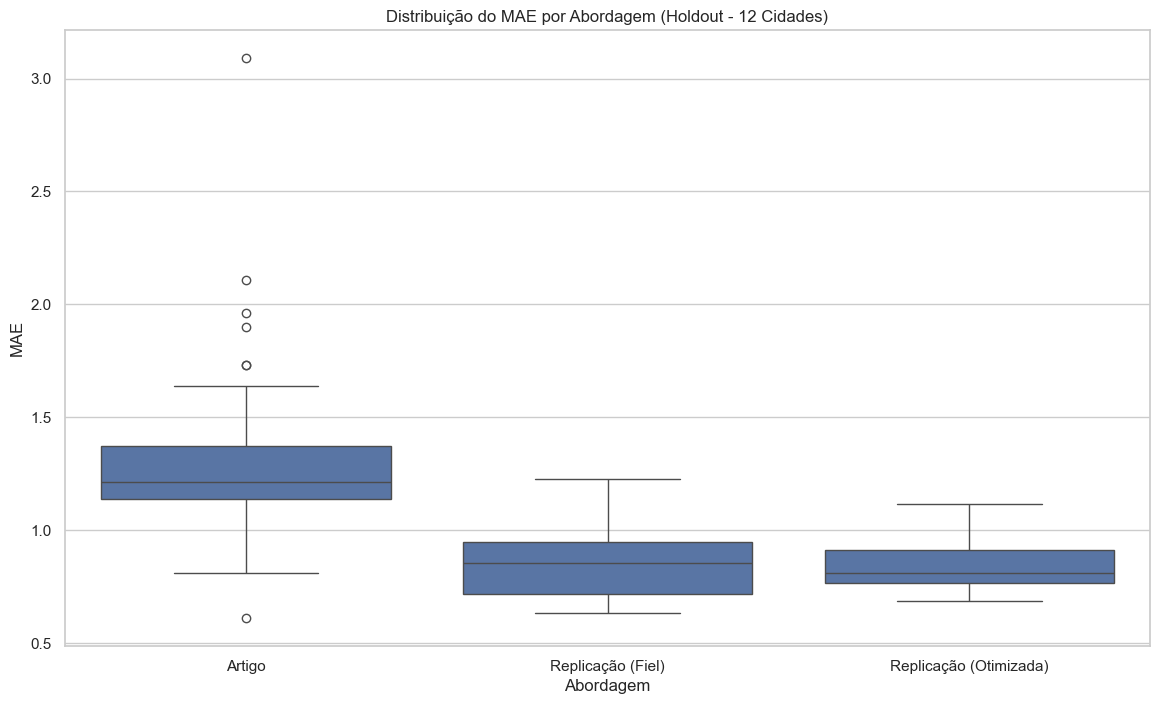

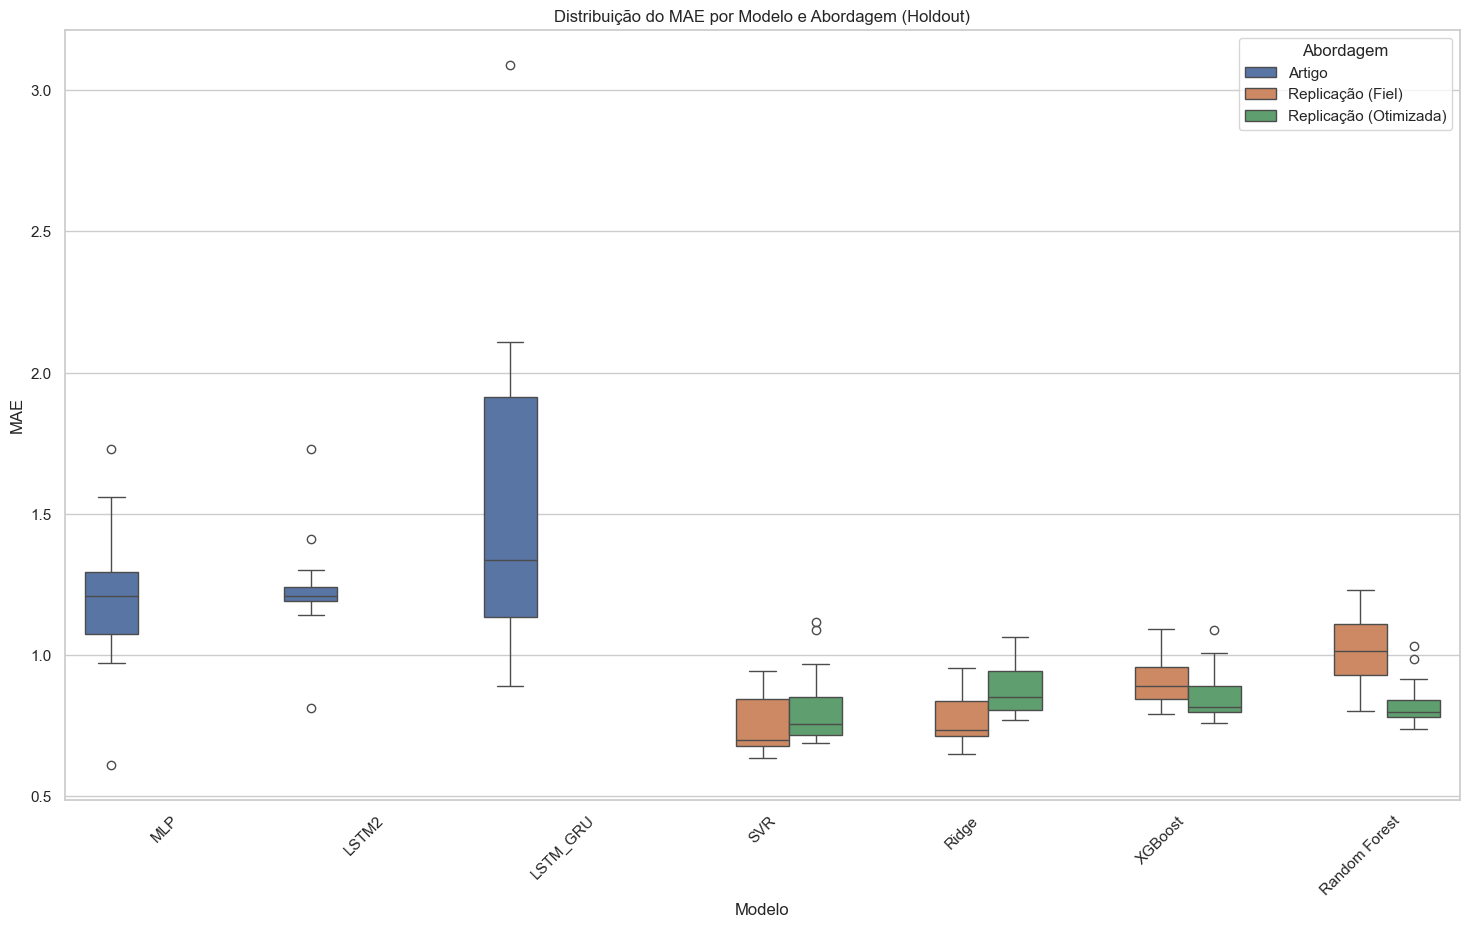

In [120]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df_holdout_combined, x='Approach', y='MAE',
            order=['Artigo', 'Replicação (Fiel)', 'Replicação (Otimizada)'])
plt.title('Distribuição do MAE por Abordagem (Holdout - 12 Cidades)')
plt.xlabel('Abordagem'); plt.ylabel('MAE')
plt.show()

plt.figure(figsize=(18,10))
sns.boxplot(data=df_holdout_combined, x='Model', y='MAE', hue='Approach')
plt.title('Distribuição do MAE por Modelo e Abordagem (Holdout)')
plt.xlabel('Modelo'); plt.ylabel('MAE'); plt.xticks(rotation=45)
plt.legend(title='Abordagem')
plt.show()

#### 6.5. Replicação Fiel vs Otimizada (pareado por cidade e modelo)

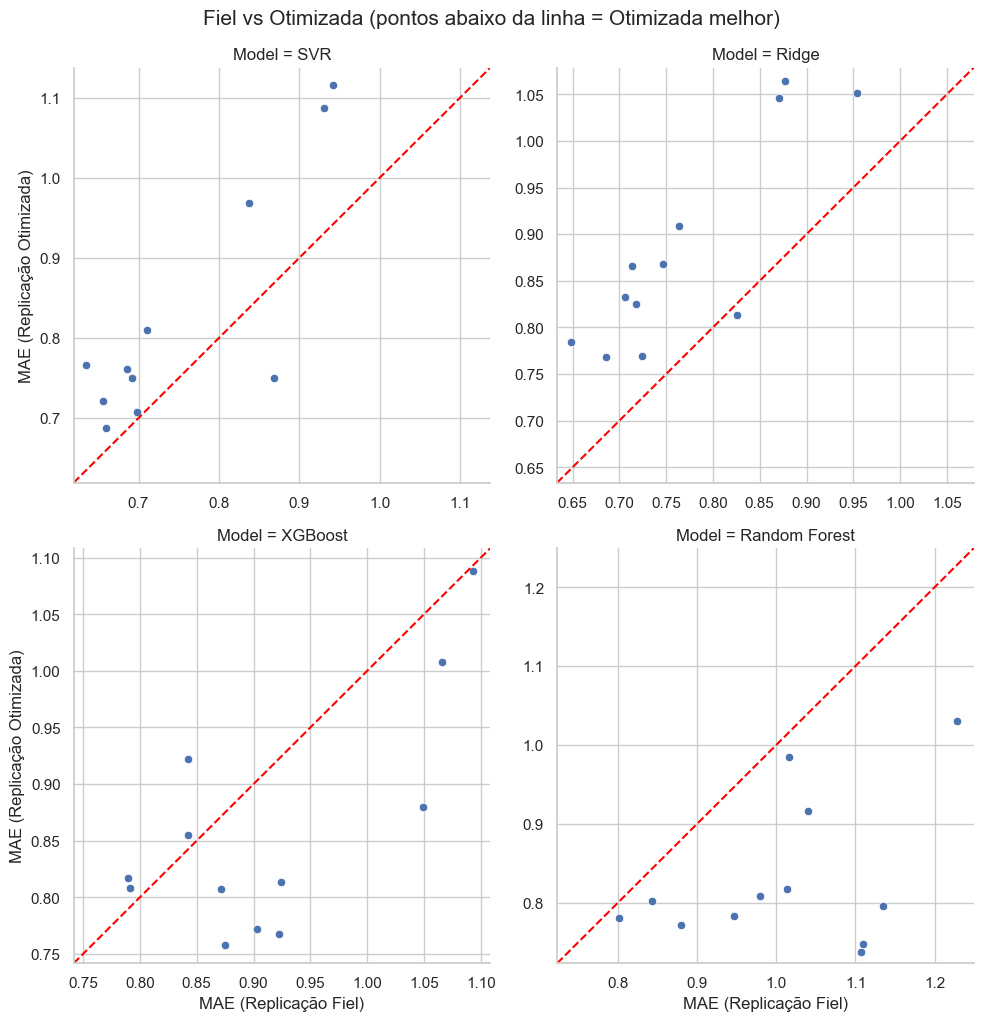

In [121]:
df_fiel = df_replica.query("Type=='Holdout' and Approach=='Replicação (Fiel)'")[['City','Model','MAE']].rename(columns={'MAE':'MAE_Fiel'})
df_otim = df_replica.query("Type=='Holdout' and Approach=='Replicação (Otimizada)'")[['City','Model','MAE']].rename(columns={'MAE':'MAE_Otimizada'})
df_pair = pd.merge(df_fiel, df_otim, on=['City','Model'])

g = sns.FacetGrid(df_pair, col="Model", col_wrap=2, height=5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="MAE_Fiel", y="MAE_Otimizada")
for ax in g.axes.flat:
    lim = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lim, lim, linestyle='--', color='red')  # y=x
    ax.set_xlim(lim); ax.set_ylim(lim)
g.set_axis_labels("MAE (Replicação Fiel)", "MAE (Replicação Otimizada)")
g.figure.suptitle("Fiel vs Otimizada (pontos abaixo da linha = Otimizada melhor)", y=1.02, fontsize=15)
plt.show()

### 7. Análise de Robustez (Backtesting)

#### 7.1. Comparação: Holdout vs. Média do Backtest (Replicação Otimizada)

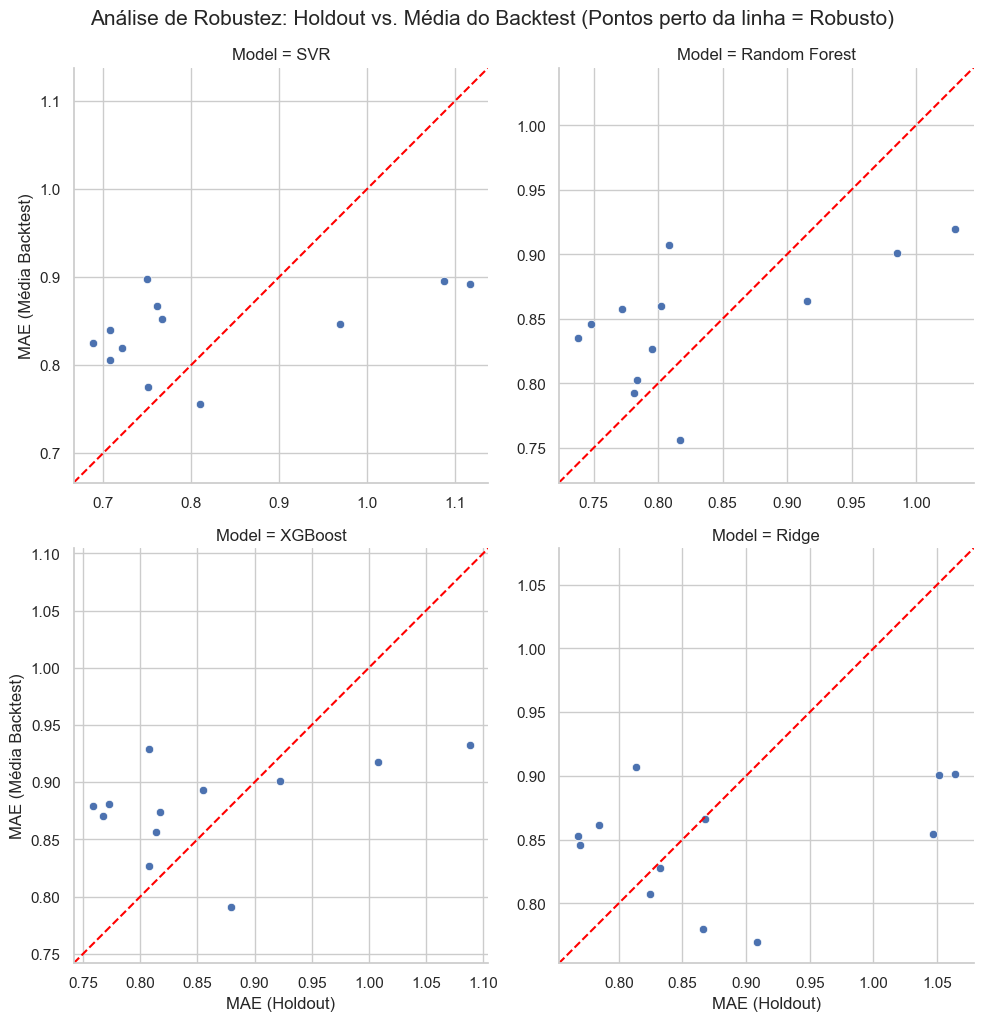

In [122]:
df_h = df_replica.query("Type=='Holdout' and Approach=='Replicação (Otimizada)'")[['City','Model','MAE']].rename(columns={'MAE':'MAE_Holdout'})
df_b = df_replica.query("Type=='Backtest_Mean' and Approach=='Replicação (Otimizada)'")[['City','Model','MAE']].rename(columns={'MAE':'MAE_Backtest_Mean'})
df_rb = pd.merge(df_h, df_b, on=['City','Model'])

g = sns.FacetGrid(df_rb, col="Model", col_wrap=2, height=5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="MAE_Holdout", y="MAE_Backtest_Mean")
for ax in g.axes.flat:
    lim = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lim, lim, linestyle='--', color='red')
    ax.set_xlim(lim); ax.set_ylim(lim)
g.set_axis_labels("MAE (Holdout)", "MAE (Média Backtest)")
g.fig.suptitle("Análise de Robustez: Holdout vs. Média do Backtest (Pontos perto da linha = Robusto)", y=1.02, fontsize=15)
plt.show()

#### 7.2. Estabilidade do Backtest (CV% por modelo)

CV% médio por modelo (menor é mais estável):


,CV% médio
Model,
SVR,7.145173
Ridge,7.266442
Random Forest,8.288763
XGBoost,9.720401


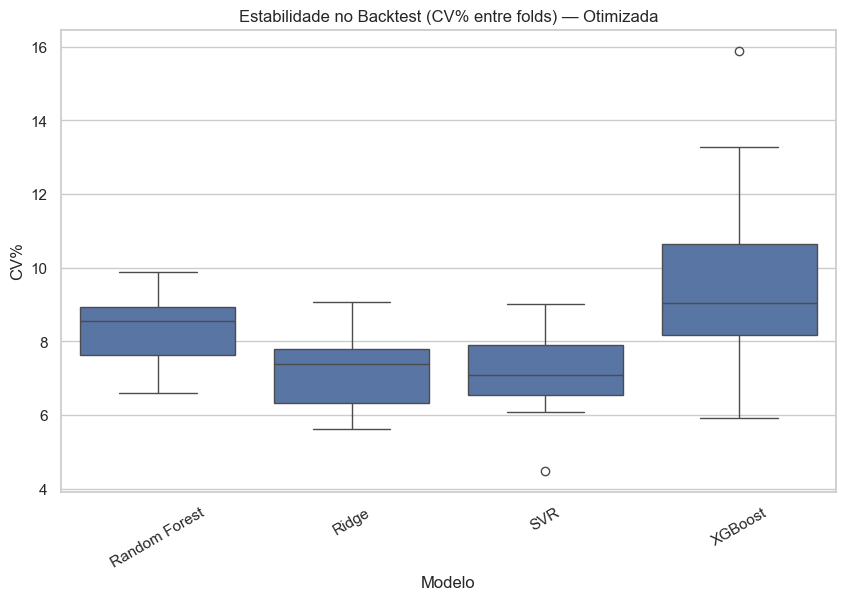

In [131]:
df_bt_full = df_replica.query("Type=='Backtest_Full' and Approach=='Replicação (Otimizada)'")
stab = (df_bt_full.groupby(['Model','City'])['MAE']
        .agg(['mean','std']).reset_index())
stab['cv_%'] = 100 * stab['std'] / stab['mean']

print("CV% médio por modelo (menor é mais estável):")
display(stab.groupby('Model')['cv_%'].mean().sort_values().to_frame('CV% médio'))

save_table_to_latex(
  df=stab.groupby('Model')['cv_%'].mean().sort_values().to_frame('CV% médio').reset_index(),
  filename='tabela_cv_medio',
  closed_table=False,
  caption="CV\% médio por modelo — Replicação Otimizada",
  label="tab:cv_medio"
)

plt.figure(figsize=(10,6))
sns.boxplot(data=stab, x='Model', y='cv_%')
plt.title('Estabilidade no Backtest (CV% entre folds) — Otimizada')
plt.ylabel('CV%'); plt.xlabel('Modelo'); plt.xticks(rotation=30)
plt.show()

In [135]:
metrics = ['MAE', 'MAPE', 'RMSE']
for metric in metrics:
    pivot_artigo = (df_holdout_combined
                    .query("Approach == 'Artigo'")
                    .pivot_table(index='City', columns='Model', values=metric)
                    .add_prefix(f'Artigo_{metric}_'))

    pivot_replica = (df_holdout_combined
                     .query("Approach == 'Replicação (Fiel)'")
                     .pivot_table(index='City', columns='Model', values=metric)
                     .add_prefix(f'Replica_{metric}_'))

    df_comparison = pd.concat([pivot_artigo, pivot_replica], axis=1)

    save_table_to_latex(
        df=df_comparison.reset_index(),
        filename=f'tabela_comparativa_{metric.lower()}',
        closed_table=False,
        caption=f"Comparativo de {metric} por cidade e modelo — Artigo vs Replicação (Fiel)",
        label=f"tab:comparativo_{metric.lower()}"
    )

    print(f"\nTabela comparativa ({metric}):")
    display(df_comparison.style.format("{:.2f}"))


Tabela comparativa (MAE):


Model,Artigo_MAE_LSTM2,Artigo_MAE_LSTM_GRU,Artigo_MAE_MLP,Replica_MAE_Random Forest,Replica_MAE_Ridge,Replica_MAE_SVR,Replica_MAE_XGBoost
City,,,,,,,
Barcelos,1.14,1.27,1.17,1.11,0.69,0.66,0.88
Benjamin Constant,1.22,1.64,1.09,0.88,0.65,0.63,0.79
Coari,1.21,1.31,1.21,1.11,0.72,0.70,0.90
Codajas,1.21,1.36,1.21,1.04,0.87,0.84,0.84
Eirunepe,1.73,3.09,1.02,1.13,0.71,0.66,0.92
Iaurete,1.30,2.11,1.34,0.98,0.83,0.87,0.87
Labrea,0.81,0.89,0.61,0.80,0.71,0.69,0.92
Manaus,1.21,1.96,1.24,1.23,0.95,0.93,1.09
Manicore,1.41,1.90,1.56,0.95,0.72,0.70,0.79



Tabela comparativa (MAPE):


Model,Artigo_MAPE_LSTM2,Artigo_MAPE_LSTM_GRU,Artigo_MAPE_MLP,Replica_MAPE_Random Forest,Replica_MAPE_Ridge,Replica_MAPE_SVR,Replica_MAPE_XGBoost
City,,,,,,,
Barcelos,24.20,20.50,30.20,24.44,17.06,16.45,19.81
Benjamin Constant,29.50,26.60,31.70,22.61,18.27,18.41,20.73
Coari,32.30,25.20,37.60,31.10,23.16,23.07,27.25
Codajas,52.20,35.10,52.20,44.34,39.23,39.83,40.48
Eirunepe,37.20,35.10,30.70,29.59,20.21,19.30,25.32
Iaurete,31.60,28.30,40.16,25.32,22.38,23.16,22.18
Labrea,26.62,19.20,19.50,22.17,20.03,19.84,25.22
Manaus,41.86,47.50,57.50,45.70,46.94,47.03,45.35
Manicore,30.90,26.90,39.40,21.60,17.75,17.38,18.70



Tabela comparativa (RMSE):


Model,Artigo_RMSE_LSTM2,Artigo_RMSE_LSTM_GRU,Artigo_RMSE_MLP,Replica_RMSE_Random Forest,Replica_RMSE_Ridge,Replica_RMSE_SVR,Replica_RMSE_XGBoost
City,,,,,,,
Barcelos,1.79,0.75,2.00,1.30,0.99,0.99,1.20
Benjamin Constant,2.04,1.08,1.89,1.00,0.90,0.92,0.95
Coari,2.22,0.89,2.25,1.34,1.07,1.06,1.21
Codajas,1.65,1.17,1.65,1.40,1.28,1.33,1.34
Eirunepe,3.61,1.58,1.79,1.32,1.01,1.01,1.22
Iaurete,2.43,1.15,2.75,1.26,1.18,1.22,1.19
Labrea,1.05,1.13,1.05,1.04,0.97,0.97,1.15
Manaus,2.06,1.12,2.87,1.42,1.36,1.39,1.35
Manicore,2.52,1.24,3.21,1.14,1.00,1.01,1.06


#### 7.4. Ranks Médios por Modelo (quanto menor, melhor)

Ranks médios (Otimizada):


,Rank Médio
Model,
SVR,1.583333
Random Forest,1.916667
XGBoost,2.916667
Ridge,3.583333


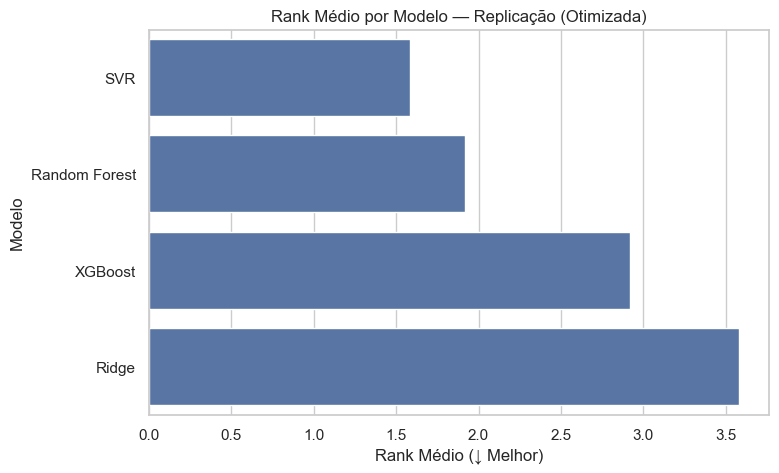

In [128]:
def mean_ranks(df, approach='Replicação (Otimizada)'):
    pivot = (df.query("Type=='Holdout' and Approach==@approach")
               .pivot_table(index='City', columns='Model', values='MAE'))
    ranks = pivot.rank(axis=1, method='average', ascending=True)
    return ranks.mean().sort_values(), ranks

mr, ranks_matrix = mean_ranks(df_holdout_combined, 'Replicação (Otimizada)')
print("Ranks médios (Otimizada):")
display(mr.to_frame('Rank Médio'))

save_table_to_latex(
  df=mr.to_frame('Rank Médio').reset_index(),
  filename='tabela_ranks_medios_otimizada',
  closed_table=False,
  caption="Ranks Médios por Modelo — Replicação Otimizada",
  label="tab:ranks_medios_otimizada"
)

plt.figure(figsize=(8,5))
sns.barplot(x=mr.values, y=mr.index, orient='h')
plt.title('Rank Médio por Modelo — Replicação (Otimizada)')
plt.xlabel('Rank Médio (↓ Melhor)'); plt.ylabel('Modelo')
plt.show()